## MICCAI Viz Random

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-02-04 22:07:57.650110: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 22:07:59.568709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 22:08:01.636628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# overall imports
import importlib
import data

# importlib.reload(data.data_utils)
# importlib.reload(data.data_load)
#importlib.reload(sim.sim_utils)
# importlib.reload(models)

import models
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results, run_simulation_set


## Results visualization

In [21]:
results_df = pd.read_csv('LM_Feb5_random.csv')
print(results_df.shape)

print(results_df['Tags'].iloc[0])

(308, 25)
cv_type_random, feature_type_transcriptome, final_eval, gene_list_0.2, hemisphere_both, model_shared_transformer, omit_subcortical_False, outerfold_1, parcellation_S100, split_random42, target_FC


In [22]:
print('original shape: ', results_df.shape)

# Get column names that we want to keep
cols_to_keep = [col for col in results_df.columns if 
                col in ['Name', 'Tags'] or 
                'final_train_metrics' in col or 
                'final_test_metrics' in col]

# Drop all other columns
results_df = results_df[cols_to_keep]
results_df.head(20)

# Extract tags into separate columns
def extract_tag_value(tag_str, prefix):
    # Find tag that starts with prefix
    for tag in tag_str.split(', '):
        if tag.startswith(prefix):
            # Return everything after the prefix
            return tag[len(prefix):]
    return None

# Define the tag prefixes we want to extract
tag_prefixes = [
    'cv_type_',
    'feature_type_', 
    'gene_list_',
    'hemisphere_',
    'model_',
    'omit_subcortical_',
    'outerfold_',
    'parcellation_',
    'split_',
    'target_'
]

# Create new columns for each tag type
for prefix in tag_prefixes:
    col_name = prefix.rstrip('_')  # Remove trailing underscore for column name
    results_df[col_name] = results_df['Tags'].apply(lambda x: extract_tag_value(x, prefix))

# Drop original Tags column if desired
results_df = results_df.drop('Tags', axis=1)

# Display first few rows to verify
results_df.head()

original shape:  (308, 25)


,Name,final_test_metrics.geodesic_distance,final_test_metrics.mae,final_test_metrics.mse,final_test_metrics.pearson_corr,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,...,cv_type,feature_type,gene_list,hemisphere,model,omit_subcortical,outerfold,parcellation,split,target
0,shared_transformer_transcriptome_FC_random_fol...,4.737491,0.067565,0.008714,0.722490,0.465766,6.533234,0.025888,0.001330,0.953224,...,random,transcriptome,0.2,both,shared_transformer,False,1,S100,random42,FC
1,dynamic_mlp_transcriptome_FC_random_fold2_fina...,5.394641,0.060876,0.008012,0.712442,0.506050,5.741144,0.016863,0.000635,0.977370,...,random,transcriptome,0.2,both,dynamic_mlp,False,2,S100,random1,FC
2,dynamic_mlp_transcriptome_FC_random_fold3_fina...,5.265468,0.063025,0.007324,0.697326,0.443209,6.652821,0.020224,0.001069,0.964695,...,random,transcriptome,0.2,both,dynamic_mlp,False,3,S100,random42,FC
3,dynamic_mlp_euclidean_SC_random_fold2_final_eval,6.856903,1.165233,5.614432,0.685102,0.431138,10.290705,0.904814,3.841435,0.802393,...,random,euclidean,0.2,both,dynamic_mlp,False,2,S100,random42,SC
4,dynamic_mlp_transcriptome_FC_random_fold2_fina...,6.277693,0.062268,0.008648,0.683656,0.466862,5.445614,0.018706,0.000764,0.974234,...,random,transcriptome,0.2,both,dynamic_mlp,False,2,S100,random1,FC


In [23]:
# Sort dataframe by final_test_metrics.pearson_corr in descending order
results_df = results_df.sort_values(by='final_test_metrics.pearson_corr', ascending=False)

# Display first few rows to verify sorting
results_df.head()
print(f"Shape before removing duplicates: {results_df.shape}")

# Keep only the row with highest pearson correlation for each unique name
results_df = results_df.sort_values('final_test_metrics.pearson_corr', ascending=False)
results_df = results_df.drop_duplicates(subset='Name', keep='first')
print(f"Shape after removing duplicates: {results_df.shape}")

Shape before removing duplicates: (308, 21)
Shape after removing duplicates: (68, 21)


In [24]:
results_df.head(20)

,Name,final_test_metrics.geodesic_distance,final_test_metrics.mae,final_test_metrics.mse,final_test_metrics.pearson_corr,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,...,cv_type,feature_type,gene_list,hemisphere,model,omit_subcortical,outerfold,parcellation,split,target
0,shared_transformer_transcriptome_FC_random_fol...,4.737491,0.067565,0.008714,0.722490,0.465766,6.533234,0.025888,0.001330,0.953224,...,random,transcriptome,0.2,both,shared_transformer,False,1,S100,random42,FC
1,dynamic_mlp_transcriptome_FC_random_fold2_fina...,5.394641,0.060876,0.008012,0.712442,0.506050,5.741144,0.016863,0.000635,0.977370,...,random,transcriptome,0.2,both,dynamic_mlp,False,2,S100,random1,FC
2,dynamic_mlp_transcriptome_FC_random_fold3_fina...,5.265468,0.063025,0.007324,0.697326,0.443209,6.652821,0.020224,0.001069,0.964695,...,random,transcriptome,0.2,both,dynamic_mlp,False,3,S100,random42,FC
3,dynamic_mlp_euclidean_SC_random_fold2_final_eval,6.856903,1.165233,5.614432,0.685102,0.431138,10.290705,0.904814,3.841435,0.802393,...,random,euclidean,0.2,both,dynamic_mlp,False,2,S100,random42,SC
5,shared_linear_encoder_transcriptome_FC_random_...,5.632873,0.068797,0.009799,0.682102,0.395876,9.738207,0.056727,0.006506,0.843653,...,random,transcriptome,0.2,both,shared_linear_encoder,False,2,S100,random1,FC
6,shared_transformer_transcriptome_FC_random_fol...,4.663766,0.065986,0.007814,0.675371,0.405929,7.364924,0.026945,0.001470,0.949747,...,random,transcriptome,0.2,both,shared_transformer,False,3,S100,random42,FC
7,shared_transformer_transcriptome_FC_random_fol...,5.153762,0.068914,0.009139,0.675309,0.436590,5.756204,0.023925,0.001190,0.956372,...,random,transcriptome,0.2,both,shared_transformer,False,2,S100,random1,FC
9,dynamic_mlp_transcriptome_FC_random_fold1_fina...,5.152926,0.069688,0.009077,0.671245,0.443489,8.770832,0.020223,0.001086,0.961251,...,random,transcriptome,0.2,both,dynamic_mlp,False,1,S100,random42,FC
10,dynamic_mlp_euclidean_SC_random_fold1_final_eval,7.496905,1.065607,4.920168,0.671084,0.424462,12.228300,1.245088,6.037034,0.695784,...,random,euclidean,0.2,both,dynamic_mlp,False,1,S100,random42,SC
11,dynamic_mlp_transcriptome_FC_random_fold0_fina...,6.722809,0.059726,0.007231,0.663533,0.424054,5.465894,0.019323,0.000902,0.975963,...,random,transcriptome,0.2,both,dynamic_mlp,False,0,S100,random1,FC


In [25]:
# Create separate dataframes based on feature types
transcriptome_df = results_df[results_df['feature_type'].isin(['transcriptome'])]
euclidean_df = results_df[results_df['feature_type'] == 'euclidean']

print(f"Shape of transcriptome models: {transcriptome_df.shape}")
print(f"Shape of euclidean-only models: {euclidean_df.shape}")

# Create separate dataframes for SC and FC targets from transcriptome models
transcriptome_sc_df = transcriptome_df[transcriptome_df['target'] == 'SC']
transcriptome_fc_df = transcriptome_df[transcriptome_df['target'] == 'FC']

# Split transcriptome SC/FC by parcellation
transcriptome_sc_s100_df = transcriptome_sc_df[transcriptome_sc_df['parcellation'] == 'S100']
transcriptome_sc_s400_df = transcriptome_sc_df[transcriptome_sc_df['parcellation'] == 'S400']
transcriptome_fc_s100_df = transcriptome_fc_df[transcriptome_fc_df['parcellation'] == 'S100']
transcriptome_fc_s400_df = transcriptome_fc_df[transcriptome_fc_df['parcellation'] == 'S400']

# Create separate dataframes for SC and FC targets from euclidean models
euclidean_sc_df = euclidean_df[euclidean_df['target'] == 'SC']
euclidean_fc_df = euclidean_df[euclidean_df['target'] == 'FC']

# Split euclidean SC/FC by parcellation 
euclidean_sc_s100_df = euclidean_sc_df[euclidean_sc_df['parcellation'] == 'S100']
euclidean_sc_s400_df = euclidean_sc_df[euclidean_sc_df['parcellation'] == 'S400']
euclidean_fc_s100_df = euclidean_fc_df[euclidean_fc_df['parcellation'] == 'S100']
euclidean_fc_s400_df = euclidean_fc_df[euclidean_fc_df['parcellation'] == 'S400']

# Sort each dataframe by model and outerfold
transcriptome_sc_s100_df = transcriptome_sc_s100_df.sort_values(['model', 'outerfold'])
transcriptome_sc_s400_df = transcriptome_sc_s400_df.sort_values(['model', 'outerfold']) 
transcriptome_fc_s100_df = transcriptome_fc_s100_df.sort_values(['model', 'outerfold'])
transcriptome_fc_s400_df = transcriptome_fc_s400_df.sort_values(['model', 'outerfold'])

euclidean_sc_s100_df = euclidean_sc_s100_df.sort_values(['model', 'outerfold'])
euclidean_sc_s400_df = euclidean_sc_s400_df.sort_values(['model', 'outerfold'])
euclidean_fc_s100_df = euclidean_fc_s100_df.sort_values(['model', 'outerfold']) 
euclidean_fc_s400_df = euclidean_fc_s400_df.sort_values(['model', 'outerfold'])


print(f"Shape of transcriptome SC models: {transcriptome_sc_df.shape}")
print(f"  S100: {transcriptome_sc_s100_df.shape}")
print(f"  S400: {transcriptome_sc_s400_df.shape}")
print(f"Shape of transcriptome FC models: {transcriptome_fc_df.shape}")
print(f"  S100: {transcriptome_fc_s100_df.shape}")
print(f"  S400: {transcriptome_fc_s400_df.shape}")
print(f"Shape of euclidean SC models: {euclidean_sc_df.shape}")
print(f"  S100: {euclidean_sc_s100_df.shape}")
print(f"  S400: {euclidean_sc_s400_df.shape}")
print(f"Shape of euclidean FC models: {euclidean_fc_df.shape}")
print(f"  S100: {euclidean_fc_s100_df.shape}")
print(f"  S400: {euclidean_fc_s400_df.shape}")



Shape of transcriptome models: (52, 21)
Shape of euclidean-only models: (16, 21)
Shape of transcriptome SC models: (28, 21)
  S100: (24, 21)
  S400: (4, 21)
Shape of transcriptome FC models: (24, 21)
  S100: (24, 21)
  S400: (0, 21)
Shape of euclidean SC models: (8, 21)
  S100: (8, 21)
  S400: (0, 21)
Shape of euclidean FC models: (8, 21)
  S100: (8, 21)
  S400: (0, 21)


In [26]:
transcriptome_sc_s100_df

,Name,final_test_metrics.geodesic_distance,final_test_metrics.mae,final_test_metrics.mse,final_test_metrics.pearson_corr,final_test_metrics.r2,final_train_metrics.geodesic_distance,final_train_metrics.mae,final_train_metrics.mse,final_train_metrics.pearson_corr,...,cv_type,feature_type,gene_list,hemisphere,model,omit_subcortical,outerfold,parcellation,split,target
200,bilinear_lowrank_transcriptome_SC_random_fold0...,9.036405,2.353678,8.482578,0.313356,0.085538,17.699124,2.322440,8.339509,0.439350,...,random,transcriptome,0.2,both,bilinear_lowrank,False,0,S100,random42,SC
104,bilinear_lowrank_transcriptome_SC_random_fold2...,7.754101,2.354056,10.409230,0.495540,0.151635,17.708530,1.802113,7.421659,0.551236,...,random,transcriptome,0.2,both,bilinear_lowrank,False,2,S100,random1,SC
141,bilinear_lowrank_transcriptome_SC_random_fold3...,7.679874,2.471144,9.930735,0.416564,0.167620,18.266614,2.125726,7.687463,0.453588,...,random,transcriptome,0.2,both,bilinear_lowrank,False,3,S100,random42,SC
159,dynamic_mlp_transcriptome_SC_random_fold0_fina...,13.451080,1.897108,11.860202,0.376335,-0.047310,25.565839,1.384176,8.065198,0.600596,...,random,transcriptome,0.2,both,dynamic_mlp,False,0,S100,random1,SC
163,dynamic_mlp_transcriptome_SC_random_fold1_fina...,13.880412,1.455828,8.460781,0.373741,0.010298,23.095429,1.231852,6.589701,0.679629,...,random,transcriptome,0.2,both,dynamic_mlp,False,1,S100,random42,SC
106,dynamic_mlp_transcriptome_SC_random_fold2_fina...,9.006331,2.010840,10.618976,0.489300,0.134540,12.985552,0.663891,2.773171,0.855664,...,random,transcriptome,0.2,both,dynamic_mlp,False,2,S100,random1,SC
240,pls_transcriptome_SC_random_fold0_final_eval,11.999850,2.425535,8.831473,0.235658,0.047925,23.521301,2.434252,9.464004,0.279326,...,random,transcriptome,0.2,both,pls,False,0,S100,random42,SC
233,pls_transcriptome_SC_random_fold2_final_eval,10.810569,2.791859,11.780869,0.252660,0.039845,22.326970,2.457179,9.486050,0.146277,...,random,transcriptome,0.2,both,pls,False,2,S100,random1,SC
197,pls_transcriptome_SC_random_fold3_final_eval,10.274685,2.752817,11.415351,0.321138,0.043182,22.171088,2.490485,9.580856,0.086193,...,random,transcriptome,0.2,both,pls,False,3,S100,random42,SC
211,shared_linear_encoder_transcriptome_SC_random_...,6.343281,2.350344,12.301288,0.295029,-0.086260,12.620375,1.065910,3.386496,0.830906,...,random,transcriptome,0.2,both,shared_linear_encoder,False,0,S100,random1,SC


In [27]:
print(f"Shape of transcriptome SC S100 models: {transcriptome_sc_s100_df.shape}")
print(f"Shape of transcriptome FC S100 models: {transcriptome_fc_s100_df.shape}")

Shape of transcriptome SC S100 models: (24, 21)
Shape of transcriptome FC S100 models: (24, 21)


In [35]:
parcellation = 's100'
transcriptome_sc = eval(f"transcriptome_sc_{parcellation}_df")
transcriptome_fc = eval(f"transcriptome_fc_{parcellation}_df") 


# Create summary stats for S100 SC models
sc_summary = transcriptome_sc.groupby('model').agg({
    'final_test_metrics.mse': ['mean', 'std'],
    'final_test_metrics.pearson_corr': ['mean', 'std'],
    'final_test_metrics.r2': ['mean', 'std'],
    'final_test_metrics.mae': ['mean', 'std'],
    'final_test_metrics.geodesic_distance': ['mean', 'std']
}).reset_index()

# Flatten column names
sc_summary.columns = ['model'] + [f'{col[0]}_{col[1]}' for col in sc_summary.columns[1:]]
sc_summary['target'] = 'SC'

# Create summary stats for S100 FC models 
fc_summary = transcriptome_fc.groupby('model').agg({
    'final_test_metrics.mse': ['mean', 'std'],
    'final_test_metrics.pearson_corr': ['mean', 'std'],
    'final_test_metrics.r2': ['mean', 'std'],
    'final_test_metrics.mae': ['mean', 'std'],
    'final_test_metrics.geodesic_distance': ['mean', 'std']
}).reset_index()

# Flatten column names
fc_summary.columns = ['model'] + [f'{col[0]}_{col[1]}' for col in fc_summary.columns[1:]]
fc_summary['target'] = 'FC'

print("\nS100 SC Summary:")
print(sc_summary)
print("\nS100 FC Summary:") 
print(fc_summary)




S100 SC Summary:
                   model  final_test_metrics.mse_mean  \
0       bilinear_lowrank                     9.607514   
1            dynamic_mlp                    10.313320   
2                    pls                    10.675898   
3  shared_linear_encoder                    11.465466   
4     shared_mlp_encoder                    17.367332   
5     shared_transformer                     9.234812   
6                xgboost                     9.077897   

   final_test_metrics.mse_std  final_test_metrics.pearson_corr_mean  \
0                    1.003170                              0.408487   
1                    1.720199                              0.413125   
2                    1.607740                              0.269818   
3                    0.844012                              0.342987   
4                    8.774081                              0.240442   
5                    0.658290                              0.485153   
6                    1.19772

In [36]:
euclidean_sc = eval(f"euclidean_sc_{parcellation}_df")
euclidean_fc = eval(f"euclidean_fc_{parcellation}_df")

# Create summary stats for S100 euclidean SC models
euclid_sc_summary = euclidean_sc.groupby('model').agg({
    'final_test_metrics.mse': ['mean', 'std'],
    'final_test_metrics.pearson_corr': ['mean', 'std'], 
    'final_test_metrics.r2': ['mean', 'std'],
    'final_test_metrics.mae': ['mean', 'std'],
    'final_test_metrics.geodesic_distance': ['mean', 'std']
}).reset_index()

# Flatten column names
euclid_sc_summary.columns = ['model'] + [f'{col[0]}_{col[1]}' for col in euclid_sc_summary.columns[1:]]

# Create summary stats for S100 euclidean FC models
euclid_fc_summary = euclidean_fc.groupby('model').agg({
    'final_test_metrics.mse': ['mean', 'std'],
    'final_test_metrics.pearson_corr': ['mean', 'std'],
    'final_test_metrics.r2': ['mean', 'std'], 
    'final_test_metrics.mae': ['mean', 'std'],
    'final_test_metrics.geodesic_distance': ['mean', 'std']
}).reset_index()

# Flatten column names
euclid_fc_summary.columns = ['model'] + [f'{col[0]}_{col[1]}' for col in euclid_fc_summary.columns[1:]]


# Get dynamic_mlp average MSE for euclidean models
dynamic_mlp_sc_mse = euclid_sc_summary[euclid_sc_summary['model'] == 'dynamic_mlp']['final_test_metrics.mse_mean'].values[0]
dynamic_mlp_fc_mse = euclid_fc_summary[euclid_fc_summary['model'] == 'dynamic_mlp']['final_test_metrics.mse_mean'].values[0]

# Print MSE values for euclidean models
print(f"\nEuclidean Model MSE Values ({parcellation}):")
print(f"Dynamic MLP SC MSE: {dynamic_mlp_sc_mse:.6f}")
print(f"Dynamic MLP FC MSE: {dynamic_mlp_fc_mse:.6f}")

# Get and print correlation values for euclidean models
dynamic_mlp_sc_corr = euclid_sc_summary[euclid_sc_summary['model'] == 'dynamic_mlp']['final_test_metrics.pearson_corr_mean'].values[0]
dynamic_mlp_fc_corr = euclid_fc_summary[euclid_fc_summary['model'] == 'dynamic_mlp']['final_test_metrics.pearson_corr_mean'].values[0]

print(f"\nEuclidean Model Correlation Values ({parcellation}):")
print(f"Dynamic MLP SC Correlation: {dynamic_mlp_sc_corr:.6f}")
print(f"Dynamic MLP FC Correlation: {dynamic_mlp_fc_corr:.6f}")



Euclidean Model MSE Values (s100):
Dynamic MLP SC MSE: 5.672989
Dynamic MLP FC MSE: 0.010220

Euclidean Model Correlation Values (s100):
Dynamic MLP SC Correlation: 0.654016
Dynamic MLP FC Correlation: 0.626064


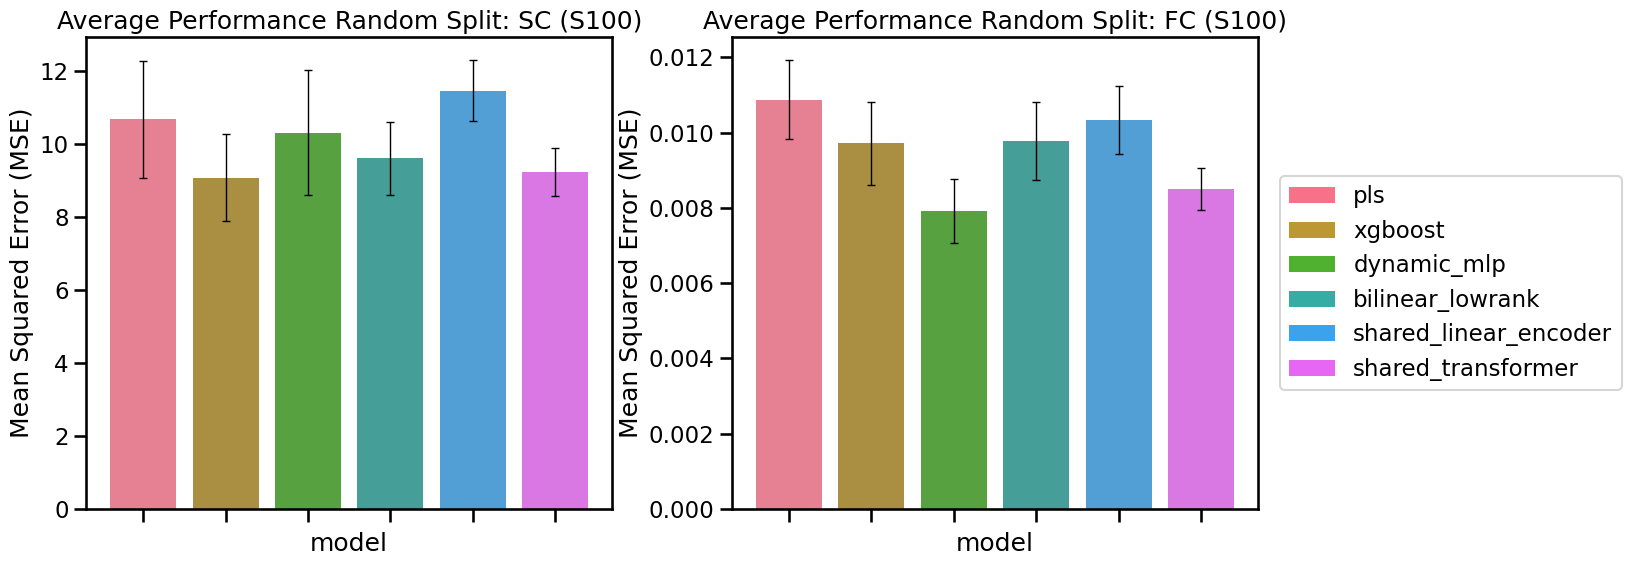

In [37]:
# Choose metric to plot
metric = 'final_test_metrics.mse'  # Can be 'final_test_metrics.pearson_corr' or 'final_test_metrics.r2'
metric_mean = f'{metric}_mean'
metric_std = f'{metric}_std'

# Define model order and color palette
model_order = ['pls', 'xgboost', 'dynamic_mlp', 'bilinear_lowrank', 
               'shared_linear_encoder', 'shared_transformer']
    
colors = sns.color_palette("husl", n_colors=len(model_order))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot SC data
bar_plot_sc = sns.barplot(data=sc_summary,
                         x='model',
                         y=metric_mean,
                         order=model_order,
                         palette=colors,
                         ci=None,
                         ax=ax1,
                         legend=False)

# Add error bars for SC
for j, model in enumerate(model_order):
    if model in sc_summary['model'].values:
        model_data = sc_summary[sc_summary['model'] == model]
        ax1.errorbar(x=j,
                    y=model_data[metric_mean].values[0],
                    yerr=model_data[metric_std].values[0],
                    color='black',
                    capsize=3,
                    capthick=1,
                    linewidth=1)

# Plot FC data
bar_plot_fc = sns.barplot(data=fc_summary,
                         x='model',
                         y=metric_mean,
                         order=model_order,
                         palette=colors,
                         ci=None,
                         ax=ax2,
                         legend=False)

# Add error bars for FC
for j, model in enumerate(model_order):
    if model in fc_summary['model'].values:
        model_data = fc_summary[fc_summary['model'] == model]
        ax2.errorbar(x=j,
                    y=model_data[metric_mean].values[0],
                    yerr=model_data[metric_std].values[0],
                    color='black',
                    capsize=3,
                    capthick=1,
                    linewidth=1)

# Get parcellation from transcriptome_sc dataframe
parcellation = transcriptome_sc['parcellation'].iloc[0]

# Customize plots
ax1.set_title(f'Average Performance Random Split: SC ({parcellation})')
ax2.set_title(f'Average Performance Random Split: FC ({parcellation})')

# Set y-axis label and limits based on metric
if metric == 'final_test_metrics.mse':
    ylabel = 'Mean Squared Error (MSE)'
elif metric == 'final_test_metrics.pearson_corr':
    ylabel = 'Pearson Correlation'
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
elif metric == 'final_test_metrics.r2':
    ylabel = 'R² Score'
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)

ax1.set_ylabel(ylabel)
ax2.set_ylabel(ylabel)

# Remove x-axis labels
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# Create legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=model) 
                  for model, color in zip(model_order, colors)]
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.show()
